In [ ]:
!curl -o dataset.zip https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/ccr8cm22vz-1.zip
!unzip dataset.zip
!unrar x "/content/Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm.rar"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  231M  100  231M    0     0  13.9M      0  0:00:16  0:00:16 --:--:-- 15.9M
Archive:  dataset.zip
  inflating: Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm.rar  

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm.rar

Creating    Palm                                                      OK
Extracting  Palm/Anemic-260 (10).png                                       0%  OK 
Extracting  Palm/Anemic-260 (11).png                                       0%  OK 
Extracting  Palm/Anemic-260 (12).png                                       0%  OK 
Extracting  Palm/Anemic-260 (2).png                                        0%  OK 
Extracting  Palm/Anemic-260 (3).png    

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

anemic = []
non_anemic = []
for filename in os.listdir('/content/Palm/'):
  if 'Non' in filename:
    non_anemic.append(filename)
  else:
    anemic.append(filename)

print(anemic, "\n",non_anemic)

['AnemicP-102.png', 'AnemicP-255 (2).png', 'AnemicP-177 (2).png', 'AnemicP-106.png', 'AnemicP-099 (10).png', 'AnemicP-233 (6).png', 'AnemicP-188 (2).png', 'Anemic-268 (11).png', 'AnemicP-022.png', 'Anemic-Pa-008 (5).png', 'AnemicP-186 (2).png', 'Anemic-Pa-001 (4).png', 'AnemicP-089 (6).png', 'AnemicP-173 (2).png', 'AnemicP-043 (11).png', 'AnemicP-201 (5).png', 'AnemicP-175 (4).png', 'AnemicP-034 (2).png', 'AnemicP-073 (2).png', 'AnemicP-029 (5).png', 'AnemicP-234 (3).png', 'AnemicP-063 (8).png', 'AnemicP-183 (2).png', 'AnemicP-001 (4).png', 'AnemicP-056 (5).png', 'AnemicP-095 (7).png', 'AnemicP-032 (12).png', 'AnemicP-100 (2).png', 'AnemicP-131 (2).png', 'AnemicP-166 (2).png', 'AnemicP-152.png', 'AnemicP-058 (8).png', 'AnemicP-012 (2).png', 'AnemicP-057 (3).png', 'AnemicP-034.png', 'Anemic-Pa-024 (3).png', 'AnemicP-040 (7).png', 'AnemicP-131.png', 'AnemicP-069 (10).png', 'AnemicP-128 (2).png', 'AnemicP-054 (4).png', 'AnemicP-072 (10).png', 'AnemicP-065 (10).png', 'AnemicP-070 (10).png'

In [ ]:
def read_img(filepath):
  img = cv2.imread(filepath)
  img = cv2.resize(img, (400, 400))
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l, a, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
  # return b
  return img

In [ ]:
dataset = []
labels = []
path = '/content/Palm/'
for filename in tqdm(anemic):
  labels.append(0)
  img = read_img(os.path.join(path, filename))
  dataset.append(img)
for filename in tqdm(non_anemic):
  labels.append(1)
  img = read_img(os.path.join(path, filename))
  dataset.append(img)

100%|██████████| 1698/1698 [00:07<00:00, 218.71it/s]


In [ ]:
dataset = np.array(dataset)
labels = np.array(labels)

In [ ]:
# dataset = np.expand_dims(dataset, axis=3)

Model definition

In [ ]:
from tensorflow import keras

def build_alexnet(in_shape, classes):
  model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=in_shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(classes,activation='softmax')
])
  return model

In [ ]:
alexnet = build_alexnet((400, 400, 3), classes=2)

In [ ]:
alexnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Preparing dataset objects for network


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

train_x, test_x, train_y, test_y = train_test_split(dataset, labels, test_size=0.2, random_state=2)
train_x = tf.data.Dataset.from_tensor_slices(train_x)
test_x = tf.data.Dataset.from_tensor_slices(test_x)
train_y = tf.data.Dataset.from_tensor_slices(train_y)
test_y = tf.data.Dataset.from_tensor_slices(test_y)

train_ds = tf.data.Dataset.zip((train_x, train_y))
test_ds = tf.data.Dataset.zip((test_x, test_y))


In [ ]:
model_callbacks = [keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=3,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=40,
)]
batch_size = 16
log = alexnet.fit(train_ds.batch(batch_size), epochs=100, verbose=2, validation_data=test_ds.batch(batch_size),
                  callbacks=model_callbacks)

Epoch 1/100
213/213 - 25s - loss: 5.8714 - accuracy: 0.5402 - val_loss: 1.1463 - val_accuracy: 0.5962 - 25s/epoch - 115ms/step
Epoch 2/100
213/213 - 9s - loss: 1.0421 - accuracy: 0.5555 - val_loss: 0.7260 - val_accuracy: 0.4754 - 9s/epoch - 43ms/step
Epoch 3/100
213/213 - 10s - loss: 0.7407 - accuracy: 0.5716 - val_loss: 0.6307 - val_accuracy: 0.6021 - 10s/epoch - 45ms/step
Epoch 4/100
213/213 - 10s - loss: 0.6873 - accuracy: 0.5863 - val_loss: 0.6205 - val_accuracy: 0.6866 - 10s/epoch - 45ms/step
Epoch 5/100
213/213 - 9s - loss: 0.6989 - accuracy: 0.5804 - val_loss: 0.6285 - val_accuracy: 0.6397 - 9s/epoch - 44ms/step
Epoch 6/100
213/213 - 9s - loss: 0.6719 - accuracy: 0.5924 - val_loss: 0.6099 - val_accuracy: 0.6514 - 9s/epoch - 44ms/step
Epoch 7/100
213/213 - 9s - loss: 0.6902 - accuracy: 0.5901 - val_loss: 0.6396 - val_accuracy: 0.6162 - 9s/epoch - 45ms/step
Epoch 8/100
213/213 - 10s - loss: 0.6755 - accuracy: 0.6115 - val_loss: 0.6128 - val_accuracy: 0.6585 - 10s/epoch - 45ms/step

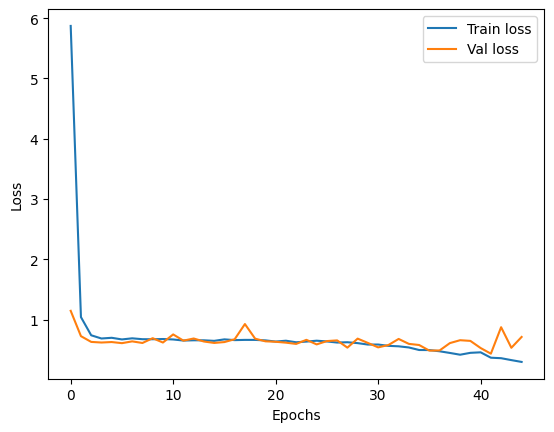

Model performance on test dataset: 
Loss: 0.4354885220527649
Accuracy: 0.8345070481300354
54/54 [==============================] - 1s 16ms/step
[[489  41]
 [100 222]]


In [ ]:
from matplotlib import pyplot as plt
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train loss", "Val loss"])
plt.show()

loss, acc = alexnet.evaluate(test_ds.batch(batch_size), verbose=0)
print("Model performance on test dataset: ")
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

y_pred = alexnet.predict(test_x.batch(batch_size))
y_pred = tf.math.argmax(
    y_pred,
    axis=1)
y_test_list = list(test_y.as_numpy_iterator())
cm = tf.math.confusion_matrix(y_test_list, y_pred).numpy()
print(cm)

In [ ]:
loss, acc = alexnet.evaluate(train_ds.batch(batch_size), verbose=0)
print("Model performance on train dataset: ")
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

y_pred = alexnet.predict(train_x.batch(batch_size))
y_pred = tf.math.argmax(
    y_pred,
    axis=1)
y_train_list = list(train_y.as_numpy_iterator())
cm = tf.math.confusion_matrix(y_train_list, y_pred).numpy()
print(cm)

Model performance on train dataset: 
Loss: 0.2310248613357544
Accuracy: 0.8943662047386169
213/213 [==============================] - 4s 16ms/step
[[1966   66]
 [ 294 1082]]


- These parameters worked best for the model


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# alexnet.save("/content/drive/MyDrive/bgr-channel-alexnet.h5") # this was just using bgr channels and the performance was surprising. Image dim-250

In [ ]:
# alexnet.save("/content/drive/MyDrive/bgr-overfit-surprizing-alexnet.h5") # this was an overfit model but the accuracy was amazing on both test and train data. Image dim-250

In [ ]:
alexnet.save("/content/drive/MyDrive/bgr-good-0.83-alexnet.h5") # this was an proper trained model and the accuracy is good. Image dim-400(couldn't do 500 due to RAM limit)